In [1]:
import pandas as pd

from urllib.request import urlopen
from bs4 import BeautifulSoup

import seaborn as sns
import matplotlib.pyplot as plt
import re

%matplotlib inline

In [2]:
sns.set(
    font_scale=2,
    style='whitegrid',
    rc={'figure.figsize': (20, 7)}
)

In [144]:
# функция парсинга тегов
def get_tags(link):
    tags_page = []
    try:
        html = urlopen(link).read().decode('utf-8')
        soup = BeautifulSoup(html,'html.parser')
        tags = soup.find_all(rel="tag")
        for tag in tags:
            tags_page.append(tag.text)
    except:
        return None
    if len(tags_page) == 0:
        return None
    return tags_page

In [3]:
filtered_df = pd.read_csv('1_filtered_df.csv')

In [4]:
filtered_df.head()

,id,time,likes,comments,reposts,views,text,ctr,url,year,month,day,tags
0,320900,1605604268,57,3,3,7159,Мужчина ухаживает за животными уже 25 лет. Де...,0.80,https://knife.media/raccoon-whisperer/,2020,2020-11,2020-11-17,"['животные', 'видео', 'люди', 'находка']"
1,320899,1605604203,33,1,5,7926,"Знаете, как добывали подноготную правду, зачем...",0.42,https://knife.media/origin-of-idioms/,2020,2020-11,2020-11-17,"['языки', 'история', 'насилие', 'россия']"
2,320894,1605600004,22,0,2,7755,"От проектов, помогающих детям-сиротам, до IT-с...",0.28,https://knife.media/edu-projects/,2020,2020-11,2020-11-17,"['партнерский материал', 'образование', 'будущ..."
3,320828,1605546303,106,0,13,14448,"Сказки братьев Гримм знают и любят и все, хотя...",0.73,https://knife.media/bratya-grimm/,2020,2020-11,2020-11-16,"['книги', 'литература', 'люди', 'россия']"
4,320815,1605544203,182,30,22,28388,"Раса, пол и гендер для дзен-буддистов — пустот...",0.64,https://knife.media/queer-zen/,2020,2020-11,2020-11-16,"['ЛГБТ', 'религия']"


In [5]:
from ast import literal_eval
filtered_df.tags = filtered_df.tags.apply(literal_eval)

In [6]:
explode_tags = filtered_df.explode('tags')

In [7]:
explode_tags.head()

,id,time,likes,comments,reposts,views,text,ctr,url,year,month,day,tags
0,320900,1605604268,57,3,3,7159,Мужчина ухаживает за животными уже 25 лет. Де...,0.80,https://knife.media/raccoon-whisperer/,2020,2020-11,2020-11-17,животные
0,320900,1605604268,57,3,3,7159,Мужчина ухаживает за животными уже 25 лет. Де...,0.80,https://knife.media/raccoon-whisperer/,2020,2020-11,2020-11-17,видео
0,320900,1605604268,57,3,3,7159,Мужчина ухаживает за животными уже 25 лет. Де...,0.80,https://knife.media/raccoon-whisperer/,2020,2020-11,2020-11-17,люди
0,320900,1605604268,57,3,3,7159,Мужчина ухаживает за животными уже 25 лет. Де...,0.80,https://knife.media/raccoon-whisperer/,2020,2020-11,2020-11-17,находка
1,320899,1605604203,33,1,5,7926,"Знаете, как добывали подноготную правду, зачем...",0.42,https://knife.media/origin-of-idioms/,2020,2020-11,2020-11-17,языки


In [8]:
explode_tags.shape

(23585, 13)

In [9]:
print(f'Количество уникальных тегов: {explode_tags.tags.nunique()}')

Количество уникальных тегов: 129


In [10]:
# количество уникальных тего по годам
explode_tags.groupby('year') \
    .agg({'tags': 'nunique'})

,tags
year,
2018,126
2019,125
2020,126


In [11]:
# из этого можно заключить, что названия тегов каждый год почти одни и те же

In [12]:
# посчитаем количество встречаемости тегов в статьях, найдём наиболее упоминаемые теги
count_tags = explode_tags.tags.value_counts()
count_tags = count_tags.reset_index().rename(columns={'index': 'tags', 'tags': 'counts'})

In [13]:
count_tags.head()

,tags,counts
0,россия,2217
1,общество,958
2,наука,890
3,психология,869
4,мир,810


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

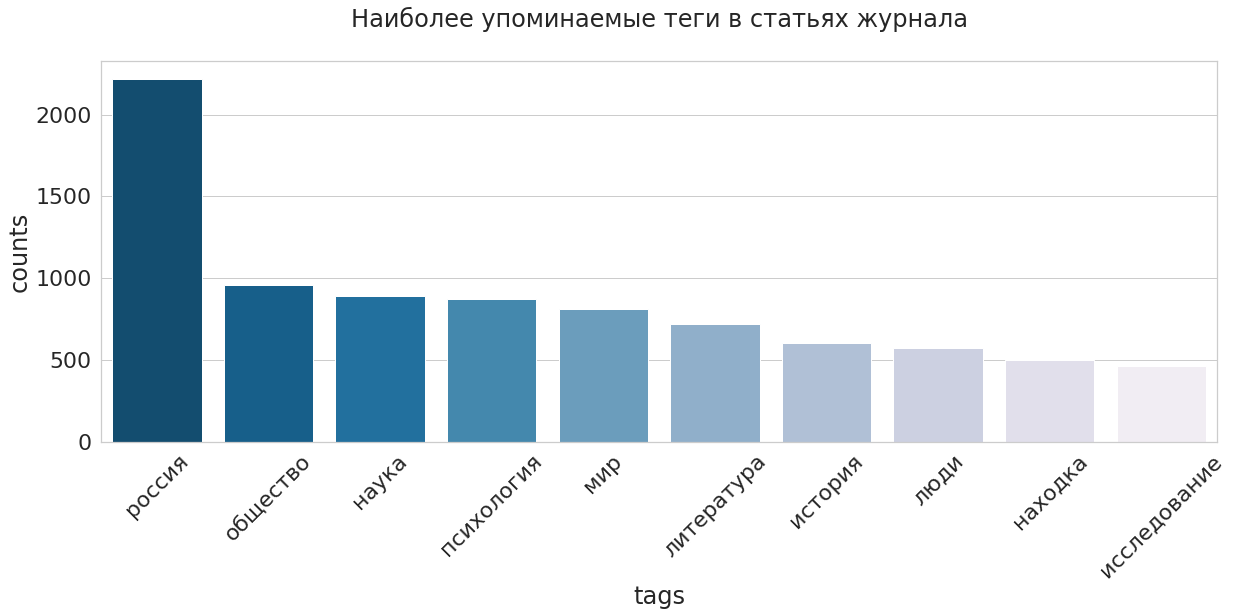

In [14]:
ax = sns.barplot(x=count_tags.head(10).tags, y=count_tags.head(10).counts, palette='PuBu_r')
ax.set_title('Наиболее упоминаемые теги в статьях журнала\n')
plt.xticks(rotation=45)

In [161]:
most_commented_tags = explode_tags.groupby('tags', as_index=False) \
    .agg({'comments': 'mean'}) \
    .sort_values('comments', ascending=False) \
    .rename(columns={'comments': 'mean_comments'}) \
    .head(10)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

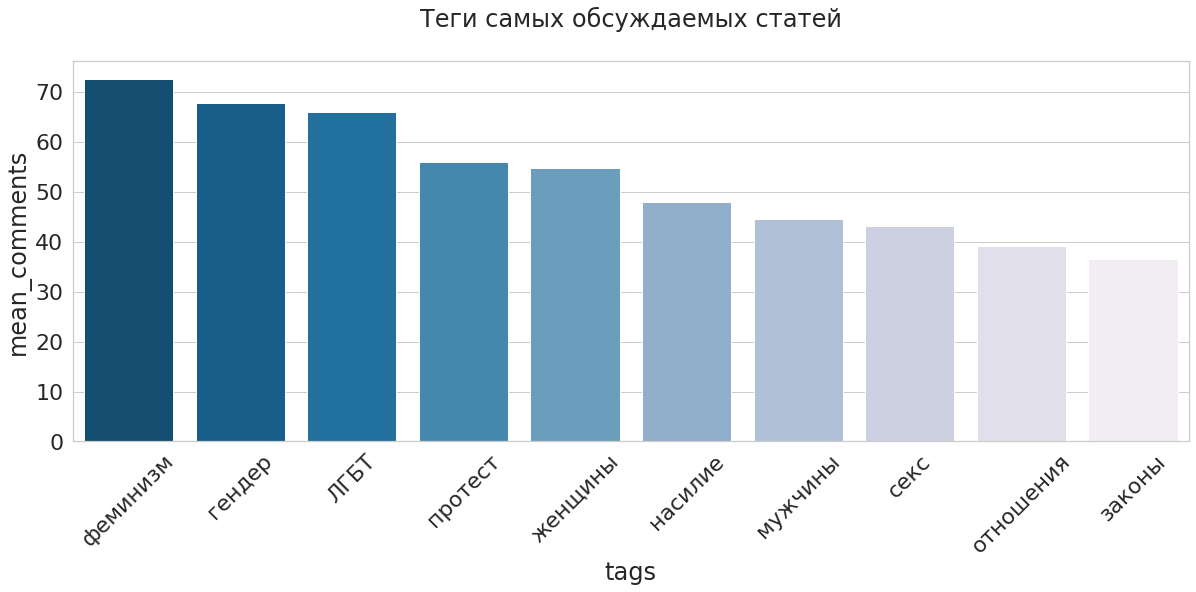

In [162]:
ax = sns.barplot(x=most_commented_tags.tags, y=most_commented_tags.mean_comments, palette='PuBu_r')
ax.set_title('Теги самых обсуждаемых статей\n')
plt.xticks(rotation=45)

In [15]:
# далее оценим худшие и лучшие теги по их среднему значению ctr

In [33]:
# задаём порог q, по которому можно отобрать теги, которые встречаются достаточно часто,
# чтобы исключить те случаи, когда среднее значение ctr редких статей будет более высокий
# из-за этого можно сделать ошибочные выводы о качестве контента для конкретных тегов
perc = 0.25
q = count_tags.counts.quantile(perc)
print(f'Отберем теги, которые упоминались хотя бы в {int(q)} статьях. Это около {int((1-perc)*100)}% тегов от их общего числа.')

Отберем теги, которые упоминались хотя бы в 46 статьях. Это около 75% тегов от их общего числа.


In [34]:
df_tags_ctr = explode_tags.merge(count_tags, on='tags').query("counts >= @q")[['tags', 'ctr']]

In [44]:
# посчитано медианное значение ctr для отобранных тегов
tags_mean_ctr = df_tags_ctr.groupby('tags', as_index=False) \
    .agg({'ctr': 'mean'}) \
    .sort_values('ctr', ascending=False) \
    .rename(columns={'ctr': 'mean_ctr'})

In [45]:
tags_mean_ctr.head()

,tags,mean_ctr
68,привычки,0.973372
55,наркотики,0.945625
50,мозг,0.945418
82,сон,0.930167
77,саморазвитие,0.911348


In [46]:
# отберем по 10 тегов с наибольшим и наименьшим mean_ctr 
best_tags_mean_ctr = tags_median_ctr.head(10)
bad_tags_mean_ctr = tags_median_ctr.tail(10)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

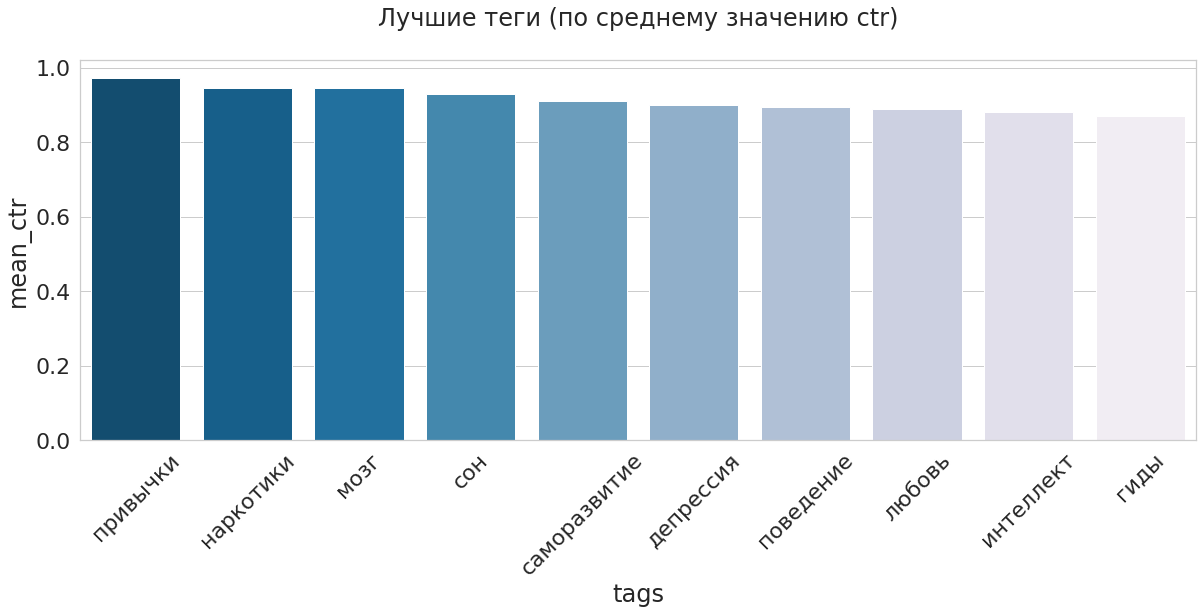

In [49]:
ax = sns.barplot(x=best_tags_mean_ctr.tags, y=best_tags_median_ctr.mean_ctr, palette='PuBu_r')
ax.set_title('Лучшие теги (по среднему значению ctr)\n')
plt.xticks(rotation=45) 

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

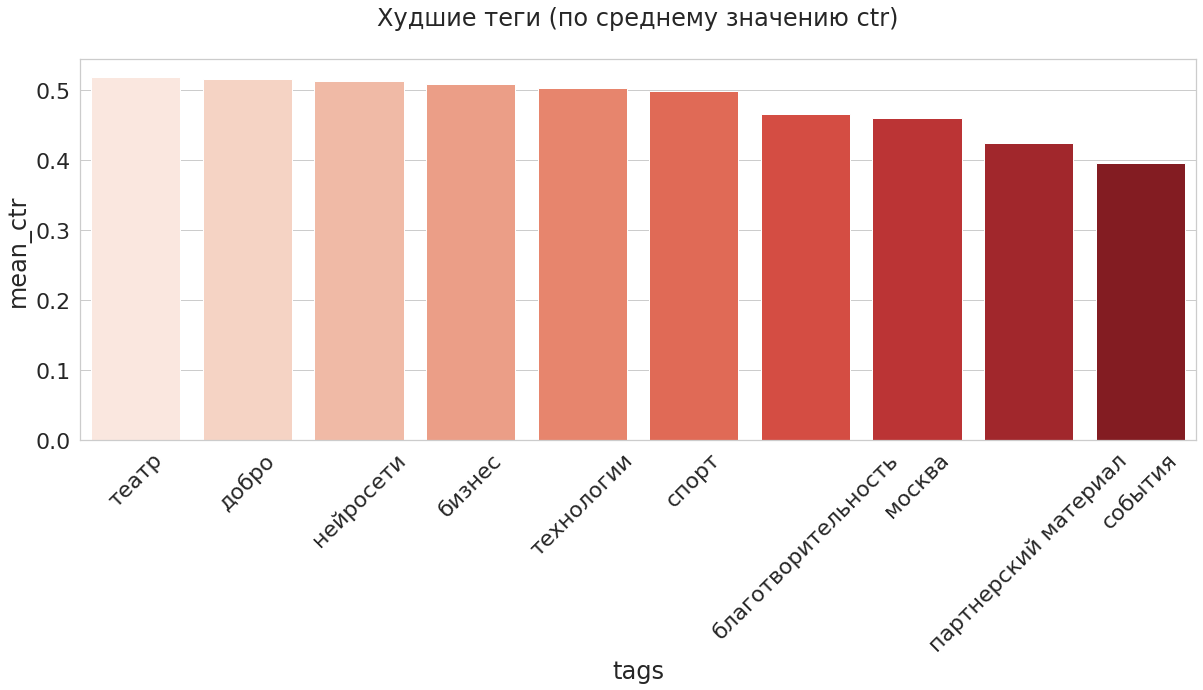

In [51]:
ax = sns.barplot(x=bad_tags_mean_ctr.tags, y=bad_tags_median_ctr.mean_ctr, palette='Reds')
ax.set_title('Худшие теги (по среднему значению ctr)\n')
plt.xticks(rotation=45) 

In [43]:
# далее сформируем два датафрейма со статьями, которые соответствуют отобранным выше тегам

In [100]:
best_tags_df = explode_tags.query("tags in @best_tags_mean_ctr.tags")
bad_tags_df = explode_tags.query("tags in @bad_tags_mean_ctr.tags")

In [101]:
best_tags_df.shape[0]

1607

In [102]:
bad_tags_df.shape[0]

1686

In [103]:
# удалим дупликаты
bad_tags_df = bad_tags_df.drop_duplicates(subset=['id']).reset_index(drop=True)[['id', 'ctr']]
best_tags_df = best_tags_df.drop_duplicates(subset=['id']).reset_index(drop=True)[['id', 'ctr']]

In [104]:
best_tags_df.shape[0]

1400

In [105]:
bad_tags_df.shape[0]

1383

In [107]:
bad_tags_df.head()

,id,ctr
0,320894,0.28
1,320760,0.49
2,320611,0.15
3,320607,0.09
4,320340,0.27


### Проверка гипотез

In [108]:
# Сформулируем гипотезы:
# H0 - распределения ctr лучших и худших тегов не отличаются
# H1 - распределения ctr лучших и худших тегов различны

Text(0.5, 1.0, 'Гистограмма ctr статей с худшими тегами\n')

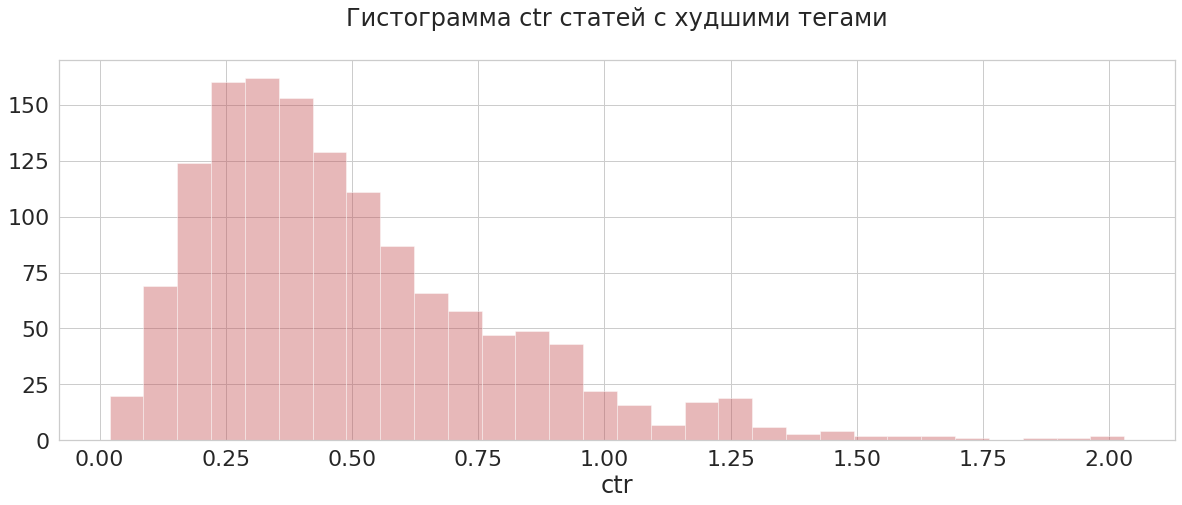

In [117]:
sns.distplot(bad_tags_df.ctr, kde=False, color="r")
plt.title('Гистограмма ctr статей с худшими тегами\n')

Text(0.5, 1.0, 'Гистограмма ctr статей с лучшими тегами\n')

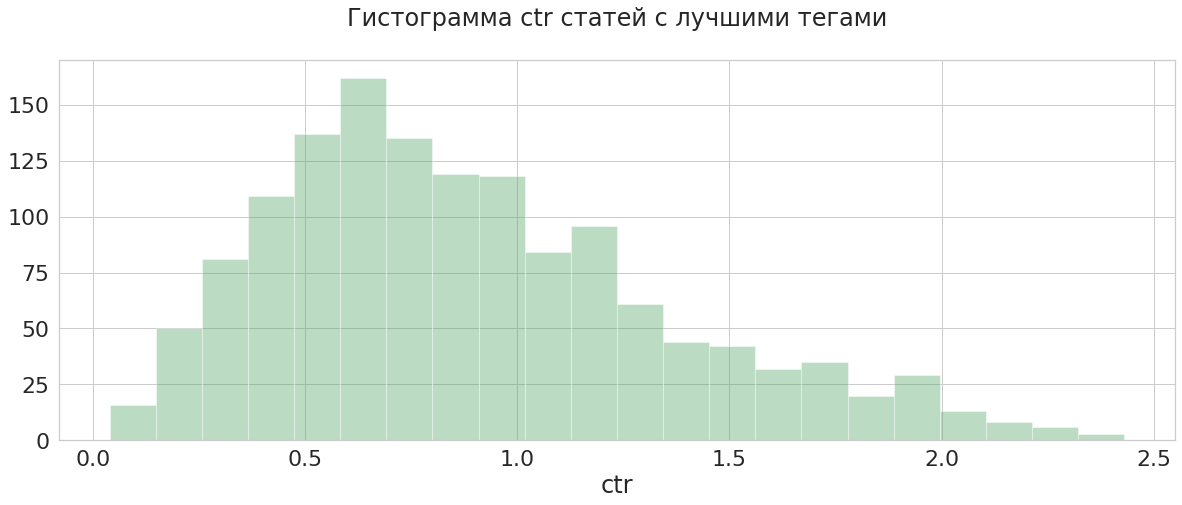

In [118]:
sns.distplot(best_tags_df.ctr, kde=False, color="g")
plt.title('Гистограмма ctr статей с лучшими тегами\n')

In [124]:
# Проверим дисперсии внутри наших групп на гомогенность, используя тест Левена
from scipy.stats import levene
levene(bad_tags_df.ctr,
      best_tags_df.ctr)

LeveneResult(statistic=208.99240616189357, pvalue=9.948082431803922e-46)

In [122]:
# условие гомогенности дисперсий не соблюдается

In [125]:
# Проверим нулевую гипотезу с помощью теста Манна-Уитни
from scipy.stats import mannwhitneyu
mannwhitneyu(bad_tags_df.ctr, best_tags_df.ctr)

MannwhitneyuResult(statistic=443291.5, pvalue=1.1301544081335858e-135)

In [126]:
# в обоих случаях p-value много меньше 0.05, что позволяет нам отклонить H0 и заключить,
# что распределения ctr лучших и худших тегов значимо различаются

In [140]:
print("Худшие теги:")
print(*list(bad_tags_median_ctr.tags), sep=', ')

Худшие теги:
театр, добро, нейросети, бизнес, технологии, спорт, благотворительность, москва, партнерский материал, события


In [141]:
print("Лучшие теги:")
print(*list(best_tags_median_ctr.tags), sep=', ')

Лучшие теги:
привычки, наркотики, мозг, сон, саморазвитие, депрессия, поведение, любовь, интеллект, гиды
